Welcome to the training notebook for the Urban Sound Classification project (NAML-2024 project by Lorenzo Gentile). 

To begin, make sure you have the following modules (the versions listed are the ones tested, may also work on others):
- tensorflow 2.13
- numpy 1.23.5
- pandas 2.0.3
- librosa 0.10.0
- matplotlib 3.7.1
- scikit-learn 1.2.2

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import datetime

from IPython.display import Audio

print("TensorFlow version: ", tf.__version__)

print(tf.config.list_physical_devices())

# this line disables GPU. For small models, CPU is faster
#tf.config.set_visible_devices([], 'GPU')

tf.keras.utils.set_random_seed(42) # for reproducibility

TensorFlow version:  2.14.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


We will be using two datasets for this project:
- The UrbanSound8K dataset, which contains 8732 labeled sound samples from 10 different classes.
- The ESC-50 dataset, which contains 2000 labeled sound samples from 50 different classes. Only 10 classes are urban sounds, (this subset is called ESC-10), but we will also test the model on the full ESC-50 dataset, to see how it performs on a larger dataset.

In the next block of code, we will define the functions to load the datasets.
Since the 2 datasets have a different folder structure, we will define 2 separate functions. 

In [2]:
PREPROCESSING_PARAMS = {
    # Dataset parameters
    'DATASET_NAME': 'UrbanSound8K', # Choose between 'ESC-10' and 'UrbanSound8K'
    'URBANSOUND8K_TESTFOLD': 10, # Choose between 1 and 10
    'ESC_TESTFOLD': 5, # Choose between 1 and 5
    'WHOLE_ESC_50': False, # If True, the whole ESC-50 dataset is used instead of ESC-10
    'TARGET_SR': 16000,
    
    'DATA_AUGMENTATION': True, # True activates data augmentation, False deactivates it
    'AUGMENTATION_FACTOR': 0.5, # Increase the number of samples by this factor (e.g. 0.5 means 50% more samples)
    # Add noise
    'ADD_NOISE': False, # True activates noise addition, False deactivates it
    'NOISE_TYPES': ['white', 'pink'], 
    'NOISE_LEVELS': [0.025, 0.025],
    'NOISE_PROBS': [0.5, 0.5],

    # Time shifting
    'TIME_SHIFT' : True, # True activates time shifting, False deactivates it
    'MAX_SHIFT': 1.5, # Maximum time shift in seconds

    # Time stretching
    'TIME_STRETCH': True, # True activates time stretching, False deactivates it
    'STRETCH_RANGE': (0.8, 1.20),  # 1 means no stretching

    # Pitch shifting
    'PITCH_SHIFT': True, # True activates pitch shifting, False deactivates it
    'PITCH_RANGE': (-2, 2), # Maximum pitch shift in semitones

    # Audio transforms
    '2D_TRANSFORMS': ['log_mel_spectrogram'], # Choose between 'spectrogram', 'mel_spectrogram', 'log_mel_spectrogram', 'mfcc', 'scalogram'
    '1D_TRANSFORMS': [], 
    
    # Spectrogram parameters
    'FRAME_LENGTH': 1024,
    'FRAME_STEP': 256,
    'FFT_LENGTH': 1024,

    # MFCC parameters
    'NUM_MEL_BINS': 64,
    'NUM_MFCCS': 64,

    # Wavelet parameters
    'NUM_SCALES': 64,
    'CWT_WAVELET': 'morl',
    'DWT_WAVELET': 'sym2',

    # Normalization
    'NORMALIZATION': 'mean_std', # Choose between 'mean_std', 'min_max', 'per_feature_mean_std', and 'none'
}

SAVED_MODELS_DIR = 'saved_models/'


In [3]:
TRAINING_PARAMS = {
    'TRAIN_SPLIT': 0.9,
    'BATCH_SIZE': 16,
    'SHUFFLE_BUFFER_PERCENT': 1,
    'NUM_EPOCHS': 50,
    'LEARNING_RATE': 0.003,
    'EARLY_STOPPING_PATIENCE': 4,
    'DROPOUT_RATE': 0.2
}

In [4]:
from scripts.dataset_loading import load_dataset

# Load the audio dataset
train_val_ds, test_ds, class_names = load_dataset(PREPROCESSING_PARAMS)

# Get the number of samples in the dataset
num_train_val_samples = len(train_val_ds)

# Get the number of classes in the dataset
num_classes = len(class_names)

# Display the class names
print(f"Class names: {class_names}")

2024-04-28 21:20:55.995500: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-04-28 21:20:55.995547: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-04-28 21:20:55.995561: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-04-28 21:20:55.995712: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-28 21:20:55.995941: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Class names: ['air_conditioner' 'car_horn' 'children_playing' 'dog_bark' 'drilling'
 'engine_idling' 'gun_shot' 'jackhammer' 'siren' 'street_music']


Now we will pad the audio samples to the maximum length in the whole dataset. This is done to ensure that all samples have the same length, which is required by the neural network, which accepts only fixed-size inputs.


In [5]:
from scripts.audio_preprocessing import apply_padding

# Pad the train_validation dataset and the test dataset
train_val_ds = apply_padding(train_val_ds, PREPROCESSING_PARAMS)
test_ds = apply_padding(test_ds, PREPROCESSING_PARAMS)

In [6]:
# Split the train_val_ds into a training dataset and a validation dataset
train_split = TRAINING_PARAMS['TRAIN_SPLIT']
num_train_samples = int(train_split * num_train_val_samples)

train_ds = train_val_ds.take(num_train_samples)
val_ds = train_val_ds.skip(num_train_samples)

In [7]:
from scripts.audio_preprocessing import augment_audio_dataset

# Augment the training dataset
if PREPROCESSING_PARAMS['DATA_AUGMENTATION']:
    train_ds = augment_audio_dataset(train_ds, PREPROCESSING_PARAMS)
    
old_num_train_samples = num_train_samples
num_train_samples = len(train_ds)

Number of training samples before augmentation: 6967
Number of training samples after augmentation: 10450
Audio shape (original): (64000,)
Audio shape (augmented): (64000,)


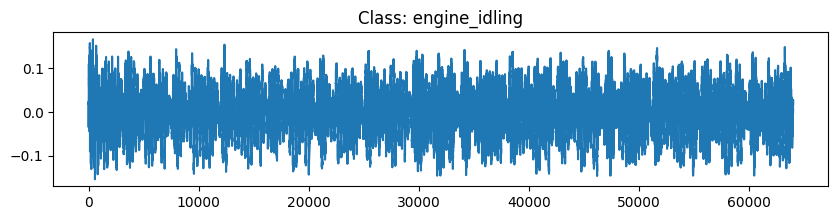

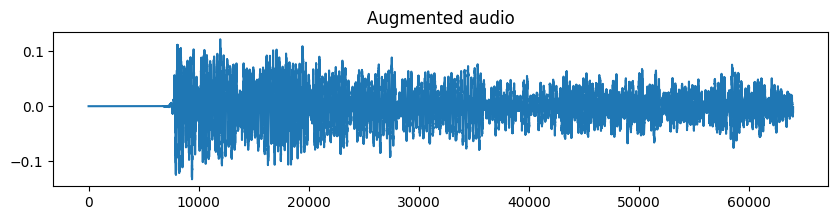

Audio shape (original): (64000,)
Audio shape (augmented): (64000,)


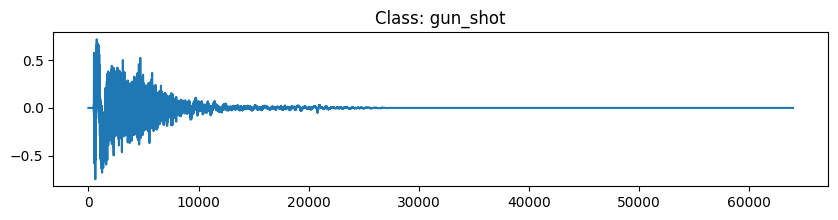

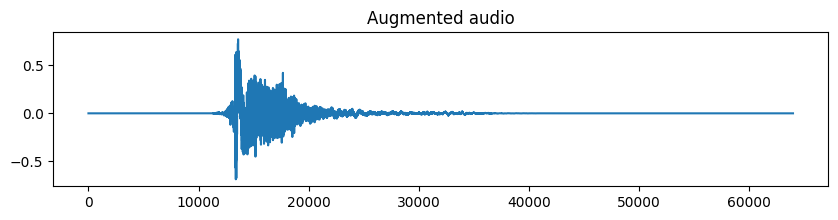

Audio shape (original): (64000,)
Audio shape (augmented): (64000,)


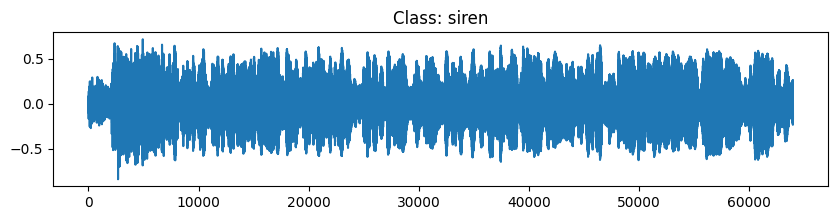

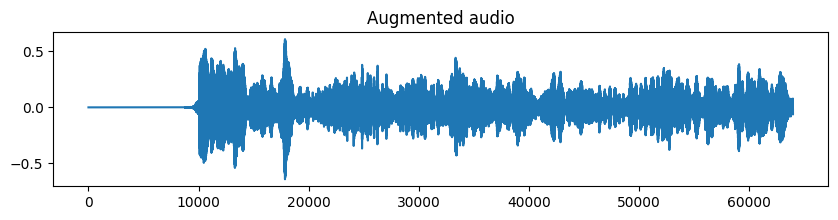

Audio shape (original): (64000,)
Audio shape (augmented): (64000,)


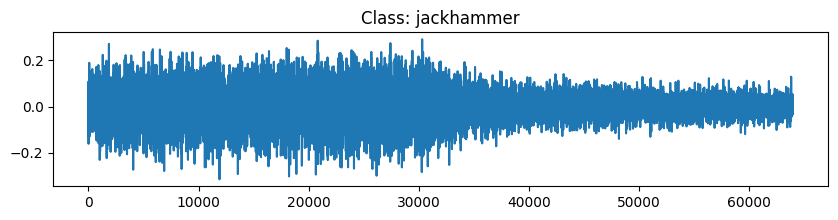

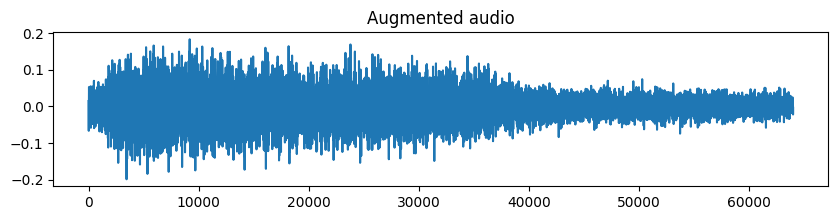

Audio shape (original): (64000,)
Audio shape (augmented): (64000,)


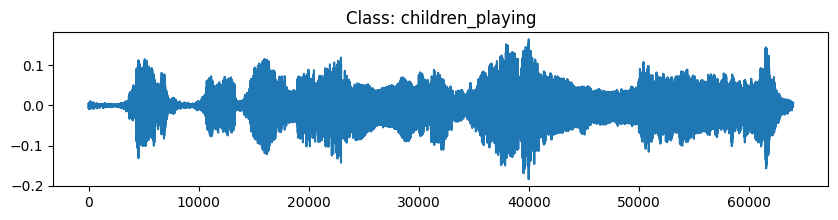

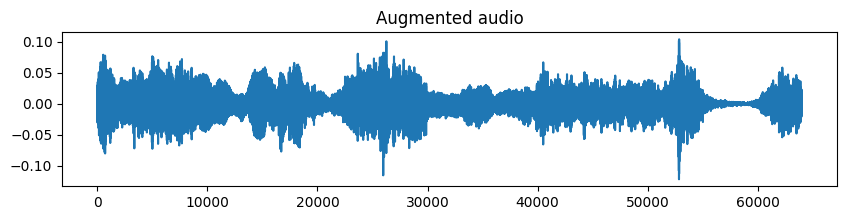

Audio shape (original): (64000,)
Audio shape (augmented): (64000,)


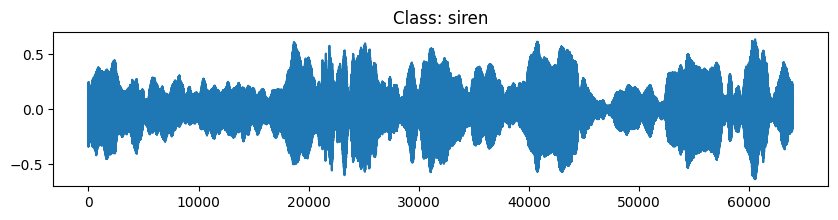

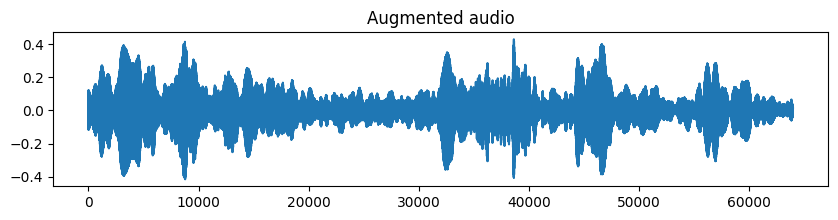

In [8]:
target_sr = PREPROCESSING_PARAMS['TARGET_SR']

if PREPROCESSING_PARAMS['DATA_AUGMENTATION']:
    print(f"Number of training samples before augmentation: {old_num_train_samples}")
    print(f"Number of training samples after augmentation: {num_train_samples}")
    # Compare the first 6 original and augmented audio clips
    for (audio, label), (audio_augmented, _) in zip(train_ds.take(6), train_ds.skip(old_num_train_samples).take(6)):
        print(f"Audio shape (original): {audio.shape}")
        print(f"Audio shape (augmented): {audio_augmented.shape}")
        display(Audio(audio, rate=target_sr))
        display(Audio(audio_augmented, rate=target_sr))
        plt.figure(figsize=(10, 2))
        plt.plot(audio)
        plt.title(f"Class: {class_names[np.argmax(label)]}")
        plt.show()
        plt.figure(figsize=(10, 2))
        plt.plot(audio_augmented)
        plt.title(f"Augmented audio")
        plt.show()
else:
    print(f"Number of training samples: {num_train_samples}")
    # Inspect the first 6 audio clips in the training set
    for audio, label in train_ds.take(6):
        print(f"Audio shape: {audio.shape}")
        display(Audio(audio, rate=target_sr))
        plt.figure(figsize=(10, 2))
        plt.plot(audio)
        plt.title(f"Class: {class_names[np.argmax(label)]}")
        plt.show()

In [9]:
from scripts.audio_preprocessing import transform_normalize_dataset

# Transform and normalize the datasets
train_ds = transform_normalize_dataset(train_ds, PREPROCESSING_PARAMS)
val_ds = transform_normalize_dataset(val_ds, PREPROCESSING_PARAMS)
test_ds = transform_normalize_dataset(test_ds, PREPROCESSING_PARAMS)

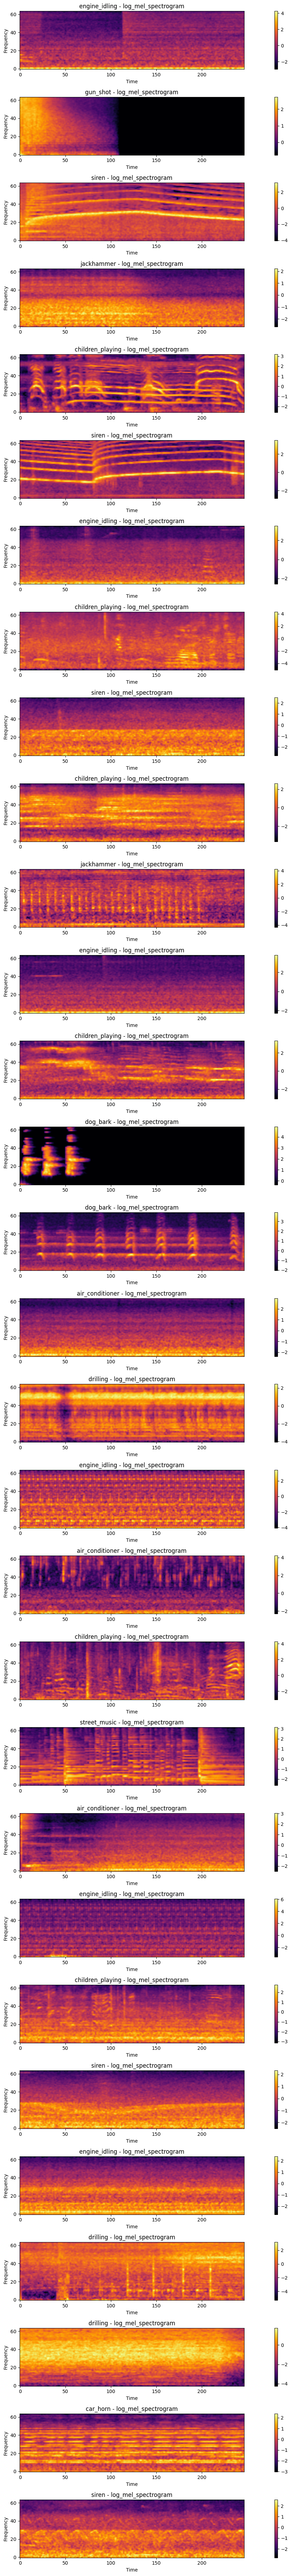

In [10]:
from scripts.plotting_utils import plot_transforms

# Plot the first 6 audio clips in the training set
plot_transforms(train_ds, class_names, PREPROCESSING_PARAMS, 30)

In the next block of code, we split the data into training, validation, and test sets and we batch the data. Splitting coefficients and batch size are modifiable hyperparameters.

In [11]:
batch_size = TRAINING_PARAMS['BATCH_SIZE']
shuffle_buffer_percent = TRAINING_PARAMS['SHUFFLE_BUFFER_PERCENT']

# Calculate the number of samples in the training, validation, and test sets
num_train_samples = len(train_ds)
shuffle_buffer_size = int(num_train_samples * shuffle_buffer_percent)

# Cache the datasets
train_ds = train_ds.cache()
val_ds = val_ds.cache()
test_ds = test_ds.cache()

# Shuffle the training dataset
train_ds = train_ds.shuffle(shuffle_buffer_size)

# Batch the datasets
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

# Prefetch the datasets
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [12]:
num_2d_transforms = len(PREPROCESSING_PARAMS['2D_TRANSFORMS'])
num_1d_transforms = len(PREPROCESSING_PARAMS['1D_TRANSFORMS'])

input_shapes_2d = [next(iter(test_ds))[0][i].shape[1:] for i in range(num_2d_transforms)]
input_shapes_1d = [next(iter(test_ds))[0][i + num_2d_transforms].shape[1:] for i in range(num_1d_transforms)]

print(f"2D input shapes: {input_shapes_2d}")
print(f"1D input shapes: {input_shapes_1d}")

2D input shapes: [TensorShape([247, 64, 1])]
1D input shapes: []


2024-04-28 21:23:02.861114: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 247, 64, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 247, 64, 16)       400       
                                                                 
 batch_normalization (Batch  (None, 247, 64, 16)       64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 247, 64, 16)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 82, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 82, 64, 32)        12800 

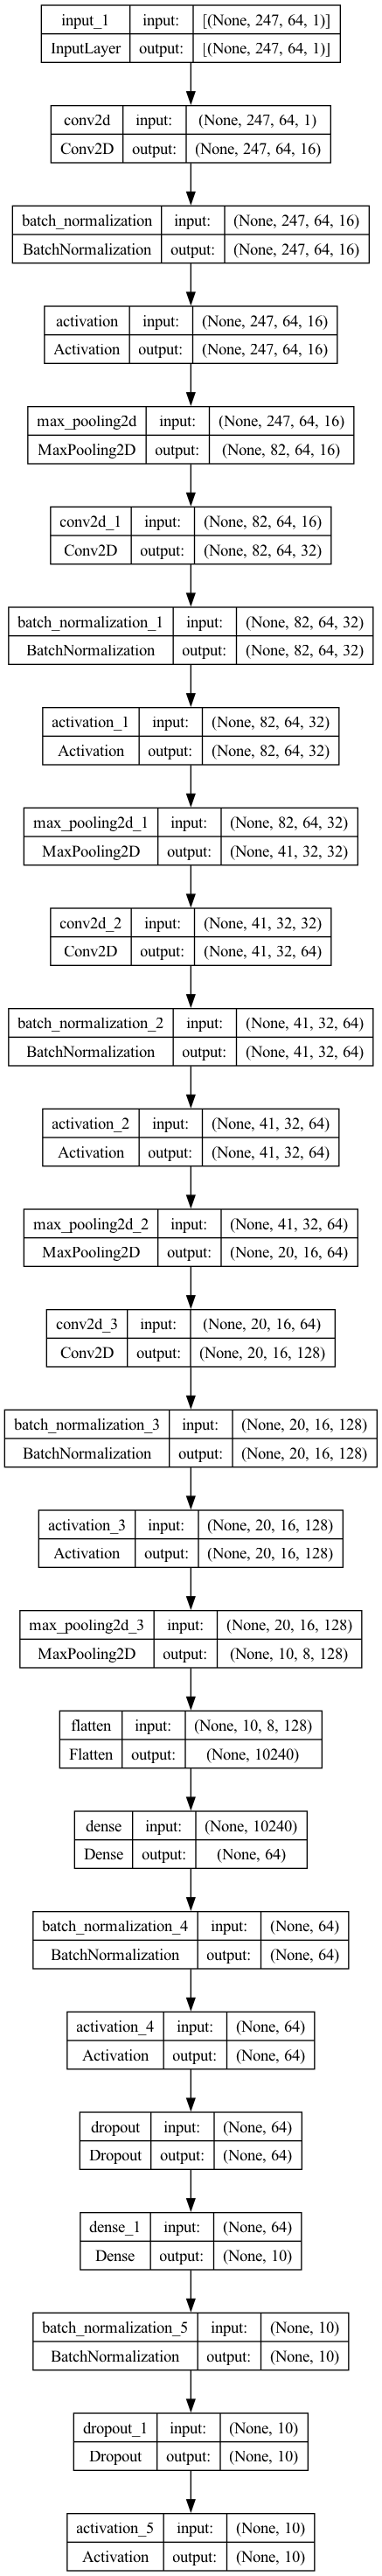

In [13]:
dropout_rate = TRAINING_PARAMS['DROPOUT_RATE']
#dropout_rate = 0.3

dropout_after_conv = False

# Define inputs for each of the transforms
inputs_2d = [tf.keras.layers.Input(shape=input_shape) for input_shape in input_shapes_2d]
inputs_1d = [tf.keras.layers.Input(shape=input_shape) for input_shape in input_shapes_1d]

filter_sizes = [(5, 5), (5, 5)]
pool_sizes = [(3, 1), (3, 2)]

# Define the first convolutional layers for each of the 2D inputs
conv = [tf.keras.layers.Conv2D(16, filter_size, use_bias=False, padding='same')(input_2d) for input_2d, filter_size in zip(inputs_2d, filter_sizes)]
batch_norm = [tf.keras.layers.BatchNormalization()(conv) for conv in conv]
activation = [tf.keras.layers.Activation('relu')(batch) for batch in batch_norm]
if dropout_after_conv:
    dropout = [tf.keras.layers.Dropout(dropout_rate)(activation) for activation in activation]
else:
    dropout = activation
maxpool = [tf.keras.layers.MaxPooling2D(pool_size)(drop) for drop, pool_size in zip(dropout, pool_sizes)]

filter_sizes = [(5, 5), (3, 3)]
pool_sizes = [(2, 2), (5, 6)]

# Define the second convolutional layers
conv = [tf.keras.layers.Conv2D(32, filter_size, use_bias=False, padding='same')(pool) for pool, filter_size in zip(maxpool, filter_sizes)]
batch_norm = [tf.keras.layers.BatchNormalization()(conv) for conv in conv]
activation = [tf.keras.layers.Activation('relu')(batch) for batch in batch_norm]
if dropout_after_conv:
    dropout = [tf.keras.layers.Dropout(dropout_rate)(activation) for activation in activation]
else:
    dropout = activation
maxpool = [tf.keras.layers.MaxPooling2D(pool_size)(drop) for drop, pool_size in zip(dropout, pool_sizes)]

filter_sizes = [(3, 3), (3, 3)]
pool_sizes = [(2, 2), (3, 3)]

# Define the third convolutional layers
conv = [tf.keras.layers.Conv2D(64, filter_size, use_bias=False, padding='same')(pool) for pool, filter_size in zip(maxpool, filter_sizes)]
batch_norm = [tf.keras.layers.BatchNormalization()(conv) for conv in conv]
activation = [tf.keras.layers.Activation('relu')(batch) for batch in batch_norm]
if dropout_after_conv:
    dropout = [tf.keras.layers.Dropout(dropout_rate)(activation) for activation in activation]
else:
    dropout = activation
maxpool = [tf.keras.layers.MaxPooling2D(pool_size)(drop) for drop, pool_size in zip(dropout, pool_sizes)]

filter_sizes = [(3, 3), (3, 3)]
pool_sizes = [(2, 2), (2, 2)]

# Define the fourth convolutional layers
conv = [tf.keras.layers.Conv2D(128, filter_size, use_bias=False, padding='same')(pool) for pool, filter_size in zip(maxpool, filter_sizes)]
batch_norm = [tf.keras.layers.BatchNormalization()(conv) for conv in conv]
activation = [tf.keras.layers.Activation('relu')(batch) for batch in batch_norm]
if dropout_after_conv:
    dropout = [tf.keras.layers.Dropout(dropout_rate)(activation) for activation in activation]
else:
    dropout = activation
maxpool = [tf.keras.layers.MaxPooling2D(pool_size)(drop) for drop, pool_size in zip(dropout, pool_sizes)]

# filter_sizes = [(3, 3), (3, 3)]
# pool_sizes = [(2, 2), (2, 2)]

# # Define the fifth convolutional layers
# conv = [tf.keras.layers.Conv2D(128, filter_size, use_bias=False, padding='same')(pool) for pool, filter_size in zip(maxpool, filter_sizes)]
# batch_norm = [tf.keras.layers.BatchNormalization()(conv) for conv in conv]
# activation = [tf.keras.layers.Activation('relu')(batch) for batch in batch_norm]
# if dropout_after_conv:
#     dropout = [tf.keras.layers.Dropout(dropout_rate)(activation) for activation in activation]
# else:
#     dropout = activation
# maxpool = [tf.keras.layers.MaxPooling2D(pool_size)(drop) for drop, pool_size in zip(dropout, pool_sizes)]


# Flatten the output of the convolutional layers
flatten = [tf.keras.layers.Flatten()(pool) for pool in maxpool]
#flatten = [tf.keras.layers.GlobalAveragePooling2D()(drop) for drop in drop]

# Conditionally concatenate the flattened outputs and the 1D inputs
if num_2d_transforms > 1:
    concat = tf.keras.layers.Concatenate()(flatten)
elif num_1d_transforms > 0:
    concat = tf.keras.layers.Concatenate()(flatten + inputs_1d)
else:
    concat = flatten[0]

# Define the first dense layer
dense = tf.keras.layers.Dense(64)(concat)
batch_norm = tf.keras.layers.BatchNormalization()(dense)
activation = tf.keras.layers.Activation('relu')(batch_norm)
dropout = tf.keras.layers.Dropout(dropout_rate)(activation)

# Define the second dense layer
dense = tf.keras.layers.Dense(num_classes)(dropout)
batch_norm = tf.keras.layers.BatchNormalization()(dense)
dropout = tf.keras.layers.Dropout(dropout_rate)(batch_norm)

# Define the softmax activation function
softmax = tf.keras.layers.Activation('softmax')(dropout)

# Define the model
model = tf.keras.models.Model(inputs=inputs_2d + inputs_1d, outputs=softmax)

# Display the model summary and plot the model
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [14]:
learning_rate = TRAINING_PARAMS['LEARNING_RATE']

# Compile the model
model.compile(tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
                metrics=['accuracy'])

In [15]:
import keras.callbacks as callbacks
from keras.callbacks import Callback

# Define callbacks
early_stopping_patience = TRAINING_PARAMS['EARLY_STOPPING_PATIENCE']

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min",
                                        patience=early_stopping_patience,
                                        restore_best_weights=True)

# class TestSetEvaluation(Callback):
#     def __init__(self, test_data):
#         super().__init__()
#         self.test_data = test_data
#         self.test_accuracies = []

#     def on_epoch_end(self, epoch, logs=None):
#         test_loss, test_accuracy = self.model.evaluate(self.test_data, verbose=0)
#         self.test_accuracies.append(test_accuracy)
#         print(f'\nEpoch {epoch+1}: Test accuracy: {test_accuracy:.4f}')

# # Instantiate the callback with your test dataset
# test_set_evaluation_callback = TestSetEvaluation(test_ds)

In [16]:
# Train the model
num_epochs = TRAINING_PARAMS['NUM_EPOCHS']

model.fit(train_ds,
          validation_data=val_ds,
          epochs=num_epochs,
          callbacks=[tensorboard_callback, earlystopping])

Epoch 1/50


2024-04-28 21:23:09.317334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-04-28 21:23:19.622681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 526 of 10450
2024-04-28 21:23:29.635870: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 1130 of 10450
2024-04-28 21:23:49.629637: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 2341 of 10450
2024-04-28 21:24:09.621484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 3673 of 10450
2024-04-28 21:24:19.621751: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 

654/654 [==============================] - 606s 367ms/step - loss: 1.4971 - accuracy: 0.4916 - val_loss: 0.7964 - val_accuracy: 0.7587
Epoch 2/50
654/654 [==============================] - 133s 203ms/step - loss: 1.0767 - accuracy: 0.6375 - val_loss: 0.6222 - val_accuracy: 0.8310
Epoch 3/50
654/654 [==============================] - 125s 192ms/step - loss: 0.9007 - accuracy: 0.6921 - val_loss: 0.6729 - val_accuracy: 0.7703
Epoch 4/50
654/654 [==============================] - 91s 139ms/step - loss: 0.7466 - accuracy: 0.7429 - val_loss: 0.8740 - val_accuracy: 0.7110
Epoch 5/50
654/654 [==============================] - 89s 136ms/step - loss: 0.6884 - accuracy: 0.7558 - val_loss: 0.4395 - val_accuracy: 0.8761
Epoch 6/50
654/654 [==============================] - 91s 139ms/step - loss: 0.6174 - accuracy: 0.7796 - val_loss: 0.3789 - val_accuracy: 0.8645
Epoch 7/50
654/654 [==============================] - 87s 133ms/step - loss: 0.5689 - accuracy: 0.7891 - val_loss: 0.3665 - val_accuracy: 

In [18]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

62/62 [==============================] - 5s 78ms/step - loss: 1.2317 - accuracy: 0.6737


In [ ]:
from scripts.model_utils import save_model

# Save the model
save_model(model, SAVED_MODELS_DIR, PREPROCESSING_PARAMS, TRAINING_PARAMS, test_accuracy)